# **🧠A Clear and Practical Hybrid Deep Learning Model for Fashion Image Classification**

# 🧑‍💻 MODEL TRAINING

## 1️⃣Imports & Environment Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, time, random

sns.set_theme(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

base_dir = "results"
sub_dirs = ["confusion_matrices", "training_curves", "gradcam", "class_accuracy", "models"]
os.makedirs(base_dir, exist_ok=True)
for d in sub_dirs:
    os.makedirs(os.path.join(base_dir, d), exist_ok=True)

start_time = time.time()
print("✅ Environment ready. TensorFlow version:", tf.__version__)

✅ Environment ready. TensorFlow version: 2.19.0


## 2️⃣ Data Loading & Preparation

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

train_images = train_images.astype('float32') / 255.0
test_images  = test_images.astype('float32') / 255.0

from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

from tensorflow.keras.utils import to_categorical
train_labels_cat = to_categorical(train_labels, 10)
val_labels_cat   = to_categorical(val_labels, 10)
test_labels_cat  = to_categorical(test_labels, 10)

## 3️⃣ Visualize Sample Images

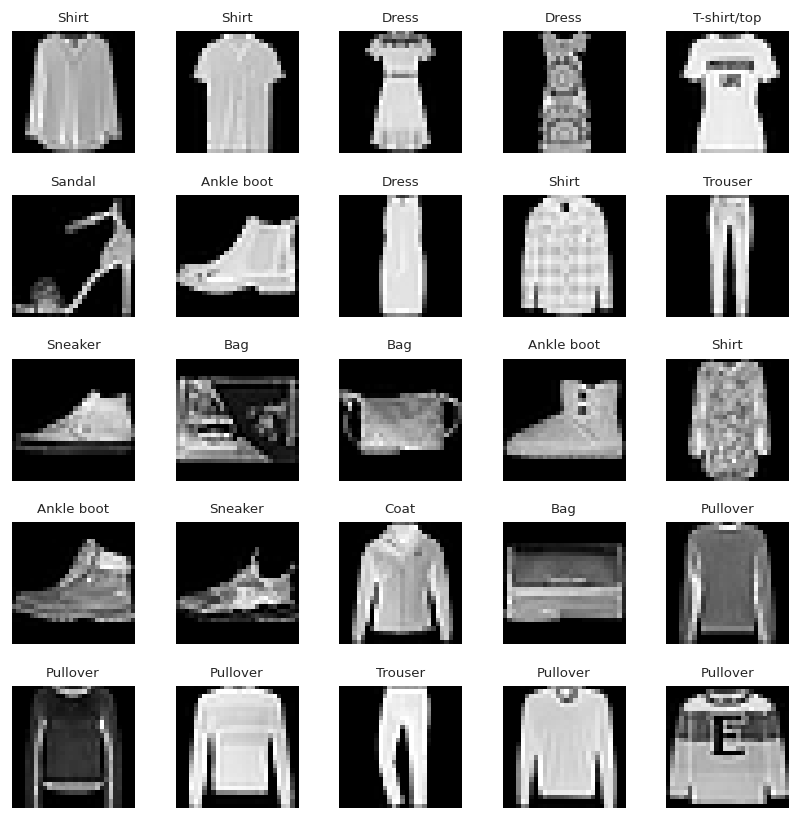

In [ ]:
def show_sample_images():
    plt.figure(figsize=(7,7))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(train_images[i], cmap='gray')
        plt.title(class_names[train_labels[i]], fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{base_dir}/sample_images.png")
    plt.show()

show_sample_images()

## 4️⃣ Data Augmentation Layer

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.10)
], name="data_augmentation")
data_augmentation.trainable = True

## 5️⃣ LC3 Learning Rate Scheduler

In [ ]:
def lc3_scheduler(epoch):
    warmup_epochs = 5
    total_epochs = 25
    base_lr, max_lr, min_lr = 1e-4, 0.003, 1e-5

    if epoch < warmup_epochs:
        return base_lr + (max_lr - base_lr) * (epoch / warmup_epochs)

    cosine_epochs = total_epochs - warmup_epochs
    epoch_adj = epoch - warmup_epochs
    cosine_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch_adj / cosine_epochs))

    if epoch > total_epochs * 0.8:
        cosine_lr *= 0.3
    return cosine_lr

from tensorflow.keras.callbacks import LearningRateScheduler
lr_callback = LearningRateScheduler(lc3_scheduler, verbose=0)

## 6️⃣ Build ANN Model – Architecture

In [ ]:
def build_ann():
    model = models.Sequential([
        layers.Input(shape=(28,28)),
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(), layers.Dropout(0.40),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(), layers.Dropout(0.25),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.30),
        layers.Dense(10, activation='softmax')
    ])
    return model

### Compile & Summary – ANN Model

In [ ]:
ann_model = build_ann()
ann_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
ann_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,506 (2.18 MB)

 Trainable params: 568,970 (2.17 MB)

 Non-trainable params: 1,536 (6.00 KB)

## 7️⃣ Build CNN Model – Architecture (Grad-CAM Compatible)

In [ ]:
def depthwise_block(x, filters, dropout=0.3):
    x = layers.DepthwiseConv2D(3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 1, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    return x

def build_cnn():
    inputs = layers.Input(shape=(28,28,1))
    x = data_augmentation(inputs)
    x = depthwise_block(x, 32, 0.25)
    x = layers.MaxPooling2D(2)(x)
    x = depthwise_block(x, 64, 0.25)
    x = layers.MaxPooling2D(2)(x)
    x = depthwise_block(x, 128, 0.30)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.40)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

### Compile & Summary – CNN Model

In [ ]:
train_images_cnn = train_images[..., np.newaxis]
val_images_cnn   = val_images[..., np.newaxis]
test_images_cnn  = test_images[..., np.newaxis]

cnn_model = build_cnn()
cnn_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)
cnn_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 28, 28, 1)      │            10 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_4              │ (None, 14, 14, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_5              │ (None, 7, 7, 64)       │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 30,552 (119.34 KB)

 Trainable params: 29,910 (116.84 KB)

 Non-trainable params: 642 (2.51 KB)

## 8️⃣ Freeze Data Augmentation Callback

In [ ]:
class FreezeAugmentation(Callback):
    def __init__(self, freeze_epoch=5):
        super().__init__()
        self.freeze_epoch = freeze_epoch
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.freeze_epoch:
            self.model.get_layer("data_augmentation").trainable = False
            print("\n📍 Data Augmentation Frozen.")

freeze_aug = FreezeAugmentation(freeze_epoch=5)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## 9️⃣ Train Both Models

In [ ]:
history_ann = ann_model.fit(
    train_images, train_labels_cat,
    validation_data=(val_images, val_labels_cat),
    epochs=25, batch_size=128,
    callbacks=[early_stop, lr_callback], verbose=1
)

history_cnn = cnn_model.fit(
    train_images_cnn, train_labels_cat,
    validation_data=(val_images_cnn, val_labels_cat),
    epochs=25, batch_size=128,
    callbacks=[early_stop, lr_callback, freeze_aug], verbose=1
)

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5396 - loss: 2.3284 - val_accuracy: 0.8177 - val_loss: 1.4493 - learning_rate: 1.0000e-04
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7868 - loss: 1.4590 - val_accuracy: 0.8563 - val_loss: 1.0973 - learning_rate: 6.8000e-04
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8181 - loss: 1.1422 - val_accuracy: 0.8517 - val_loss: 0.8737 - learning_rate: 0.0013
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8233 - loss: 0.9121 - val_accuracy: 0.8223 - val_loss: 0.7775 - learning_rate: 0.0018
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8179 - loss: 0.7875 - val_accuracy: 0.8267 - val_loss: 0.7161 - learning_rate: 0.0024
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8075 - loss: 0.7650 - val_accuracy: 0.8285 - val_loss: 0.6679 - learning_rate: 0.0030
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8077 - loss: 0

# 🧑‍💻EVALUATION & SAVING RESULTS

## 🔟 Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, x, y, name):
    loss, acc = model.evaluate(x, y, verbose=0)
    print(f"{name} Test Accuracy: {acc*100:.2f}%")
    return acc

ann_acc = evaluate_model(ann_model, test_images, test_labels_cat, "ANN")
cnn_acc = evaluate_model(cnn_model, test_images_cnn, test_labels_cat, "CNN")

ann_preds = ann_model.predict(test_images, verbose=0)
cnn_preds = cnn_model.predict(test_images_cnn, verbose=0)
ensemble_preds = (ann_preds + cnn_preds) / 2
ensemble_labels = np.argmax(ensemble_preds, axis=1)
ensemble_acc = np.mean(ensemble_labels == test_labels)

print(f"Ensemble Test Accuracy: {ensemble_acc*100:.2f}%")

ANN Test Accuracy: 87.48%
CNN Test Accuracy: 75.73%
Ensemble Test Accuracy: 86.83%


## 1️⃣1️⃣ Confusion Matrices

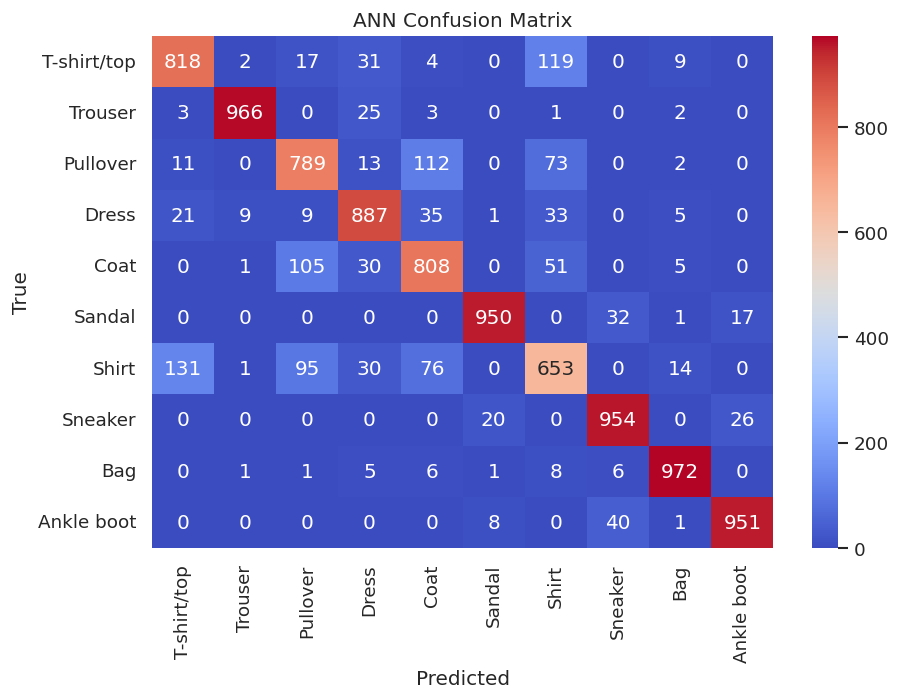

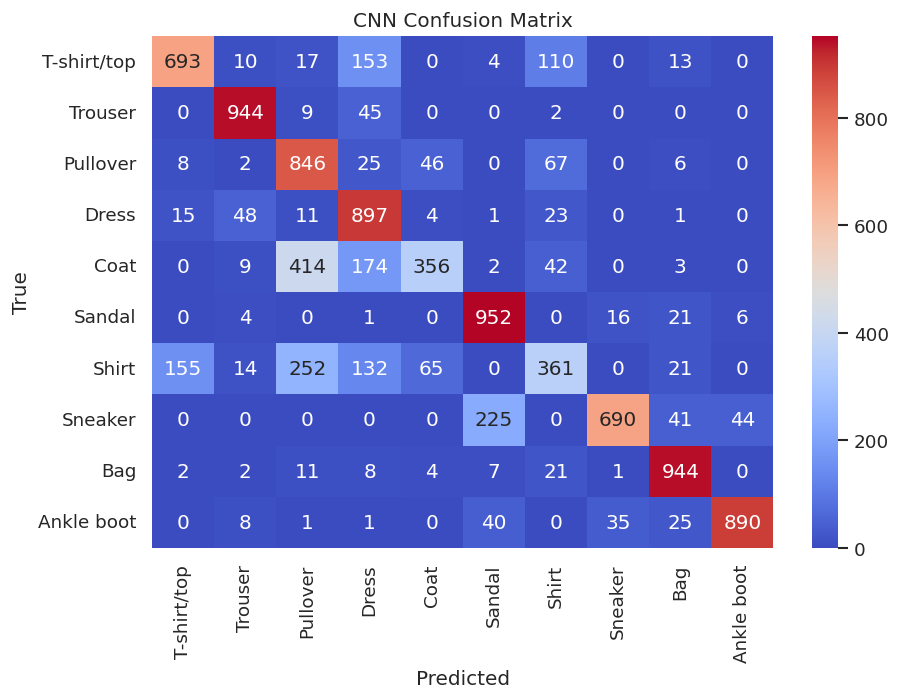

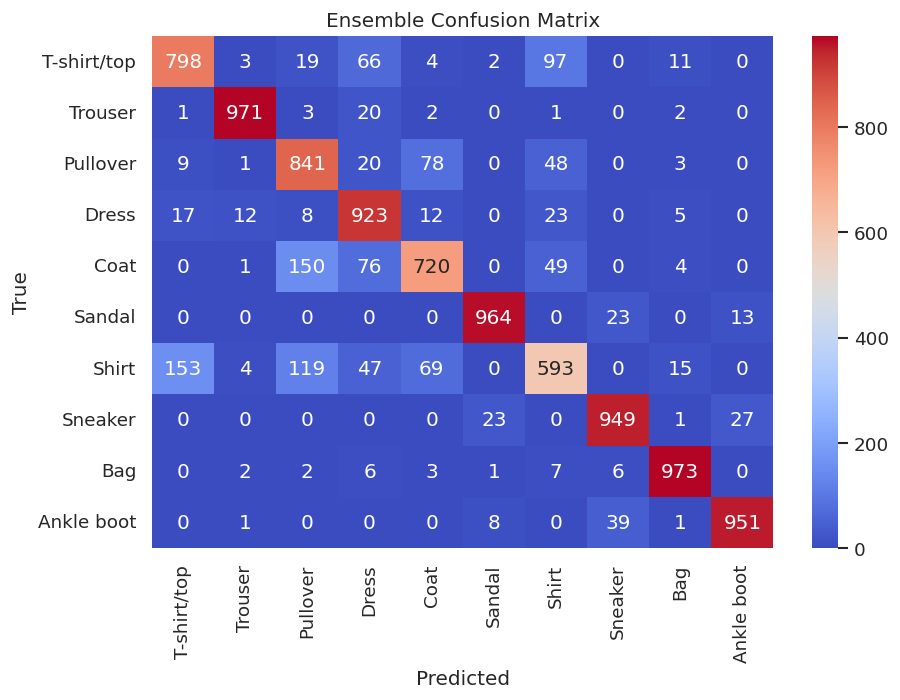

In [ ]:
def plot_confusion(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{base_dir}/confusion_matrices/{fname}")
    plt.show()

plot_confusion(test_labels, np.argmax(ann_preds, axis=1), "ANN Confusion Matrix", "ann_cm.png")
plot_confusion(test_labels, np.argmax(cnn_preds, axis=1), "CNN Confusion Matrix", "cnn_cm.png")
plot_confusion(test_labels, ensemble_labels, "Ensemble Confusion Matrix", "ensemble_cm.png")

## 1️⃣2️⃣ Class-wise Accuracy

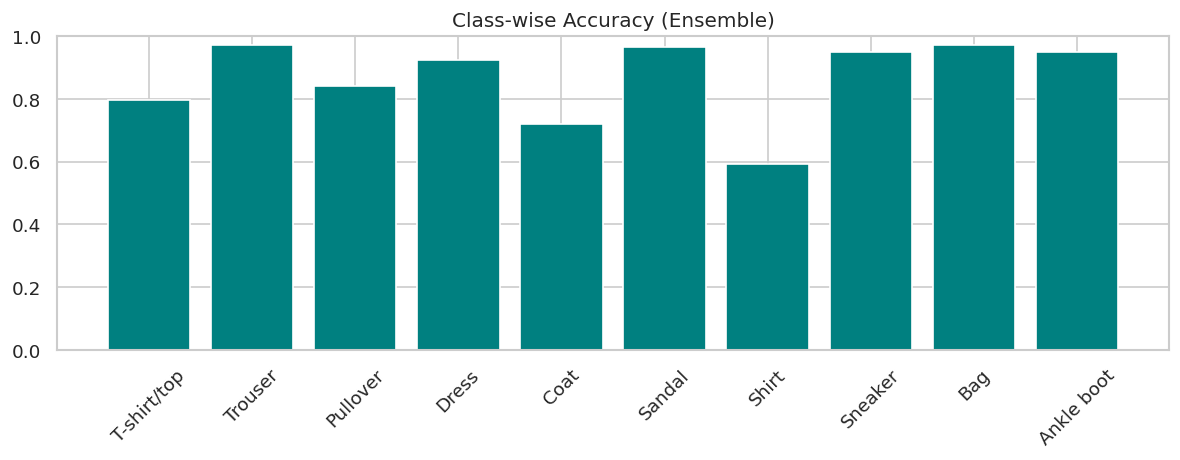

array([0.798, 0.971, 0.841, 0.923, 0.72 , 0.964, 0.593, 0.949, 0.973,
       0.951])

In [ ]:
def class_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10,4))
    plt.bar(class_names, acc, color='teal')
    plt.title("Class-wise Accuracy (Ensemble)")
    plt.xticks(rotation=45); plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(f"{base_dir}/class_accuracy/class_accuracy.png")
    plt.show()
    return acc

class_accuracy(test_labels, ensemble_labels)

## 1️⃣3️⃣ Training Curves

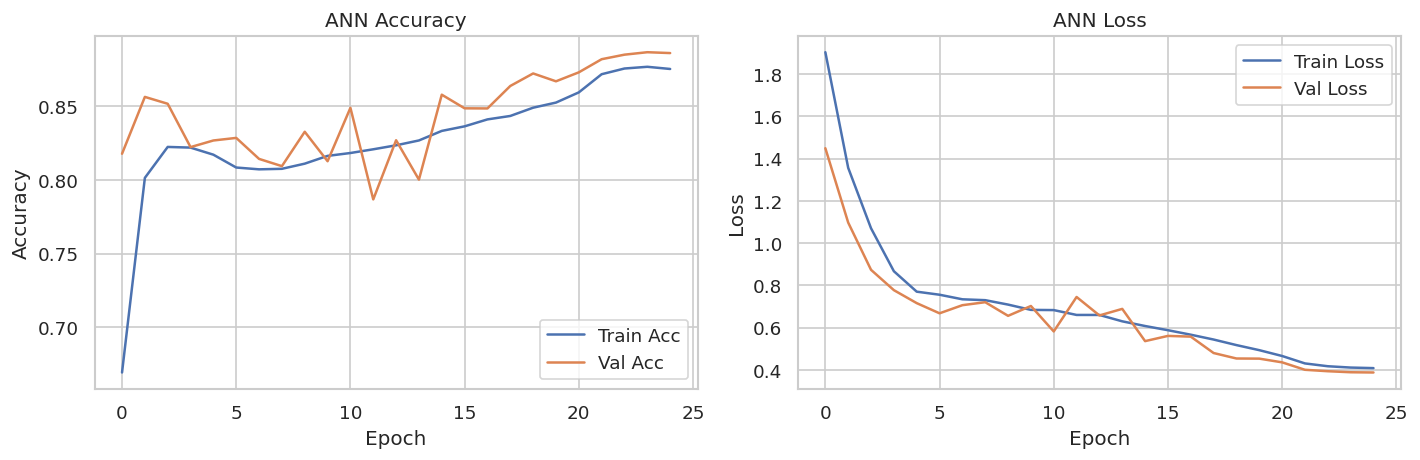

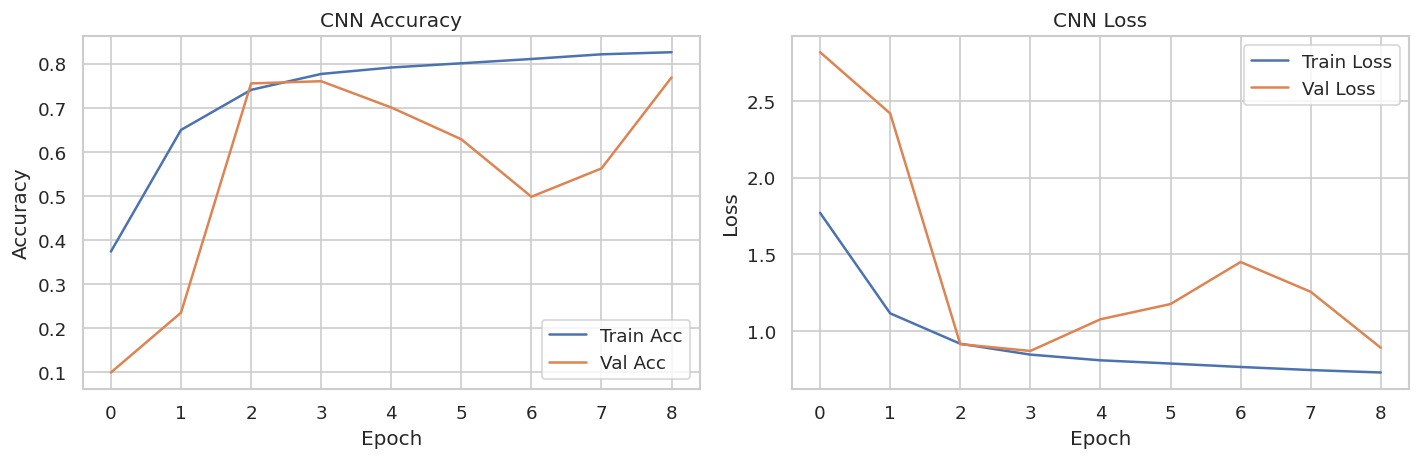

In [ ]:
def plot_training_curves(history, name):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{name} Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{base_dir}/training_curves/{name.lower()}_curves.png")
    plt.show()

plot_training_curves(history_ann, "ANN")
plot_training_curves(history_cnn, "CNN")

## 1️⃣4️⃣ Learning Rate Schedule Plot

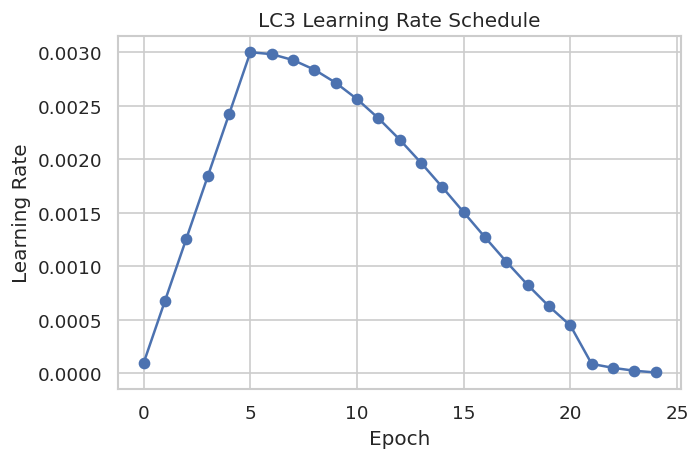

In [ ]:
lrs = [lc3_scheduler(i) for i in range(25)]
plt.figure(figsize=(6,4))
plt.plot(lrs, marker='o')
plt.title("LC3 Learning Rate Schedule")
plt.xlabel("Epoch"); plt.ylabel("Learning Rate")
plt.grid(True); plt.tight_layout()
plt.savefig(f"{base_dir}/training_curves/lr_schedule.png")
plt.show()

## 1️⃣5️⃣ Save Models & Performance Summary

In [ ]:
with open(f"{base_dir}/summary_log.txt", "w") as f:
    f.write("=== MODEL PERFORMANCE SUMMARY ===\n")
    f.write(f"ANN Test Accuracy: {ann_acc*100:.2f}%\n")
    f.write(f"CNN Test Accuracy: {cnn_acc*100:.2f}%\n")
    f.write(f"Ensemble Test Accuracy: {ensemble_acc*100:.2f}%\n")
    f.write(f"Runtime: {time.time()-start_time:.2f} seconds\n")

ann_model.save(f"{base_dir}/models/final_ann_model.keras")
cnn_model.save(f"{base_dir}/models/final_cnn_model.keras")

print("\n✅ Part 2 Completed: Evaluation, Confusion, Curves & Models Saved.")
print(f"📍 Results saved in: {base_dir}/")


✅ Part 2 Completed: Evaluation, Confusion, Curves & Models Saved.
📍 Results saved in: results/


# METRICS, GRAD-CAM

## 1️⃣6️⃣ Metrics Calculation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

new_dirs = ["metrics_comparison", "gradcam_3"]
for d in new_dirs:
    os.makedirs(os.path.join(base_dir, d), exist_ok=True)

ann_preds = ann_model.predict(test_images, verbose=0)
cnn_preds = cnn_model.predict(test_images_cnn, verbose=0)

ann_pred_labels = np.argmax(ann_preds, axis=1)
cnn_pred_labels = np.argmax(cnn_preds, axis=1)

ann_precision = precision_score(test_labels, ann_pred_labels, average='macro')
ann_recall = recall_score(test_labels, ann_pred_labels, average='macro')
ann_f1 = f1_score(test_labels, ann_pred_labels, average='macro')

cnn_precision = precision_score(test_labels, cnn_pred_labels, average='macro')
cnn_recall = recall_score(test_labels, cnn_pred_labels, average='macro')
cnn_f1 = f1_score(test_labels, cnn_pred_labels, average='macro')

ens_precision = precision_score(test_labels, ensemble_labels, average='macro')
ens_recall = recall_score(test_labels, ensemble_labels, average='macro')
ens_f1 = f1_score(test_labels, ensemble_labels, average='macro')

print("\n=== MACRO METRICS ===")
print(f"ANN:  Precision={ann_precision:.3f}, Recall={ann_recall:.3f}, F1={ann_f1:.3f}")
print(f"CNN:  Precision={cnn_precision:.3f}, Recall={cnn_recall:.3f}, F1={cnn_f1:.3f}")
print(f"ENS:  Precision={ens_precision:.3f}, Recall={ens_recall:.3f}, F1={ens_f1:.3f}")


=== MACRO METRICS ===
ANN:  Precision=0.874, Recall=0.875, F1=0.874
CNN:  Precision=0.772, Recall=0.757, F1=0.746
ENS:  Precision=0.868, Recall=0.868, F1=0.866


## 1️⃣7️⃣  Bar Graphs

In [ ]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.grid": True,
    "grid.color": "0.75",
    "axes.edgecolor": "0",
    "figure.dpi": 120
})

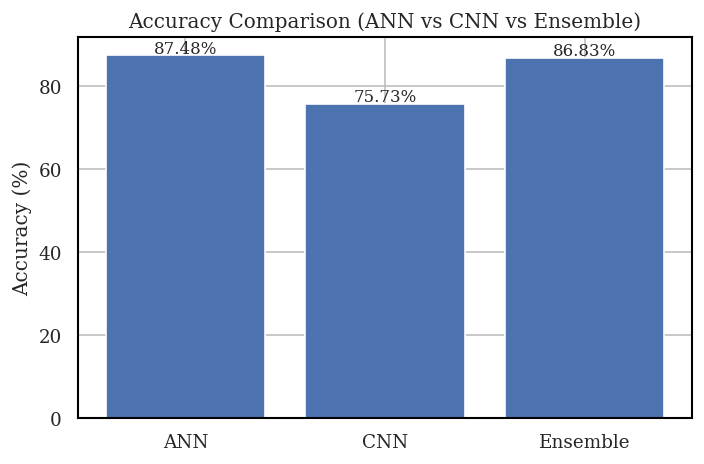

In [ ]:
plt.figure(figsize=(6,4))
models_list = ["ANN", "CNN", "Ensemble"]
acc_values = [ann_acc*100, cnn_acc*100, ensemble_acc*100]
bars = plt.bar(models_list, acc_values)

for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.5, f"{y:.2f}%", ha='center', fontsize=10)

plt.title("Accuracy Comparison (ANN vs CNN vs Ensemble)")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.savefig(f"{base_dir}/metrics_comparison/accuracy_comparison.png")
plt.show()

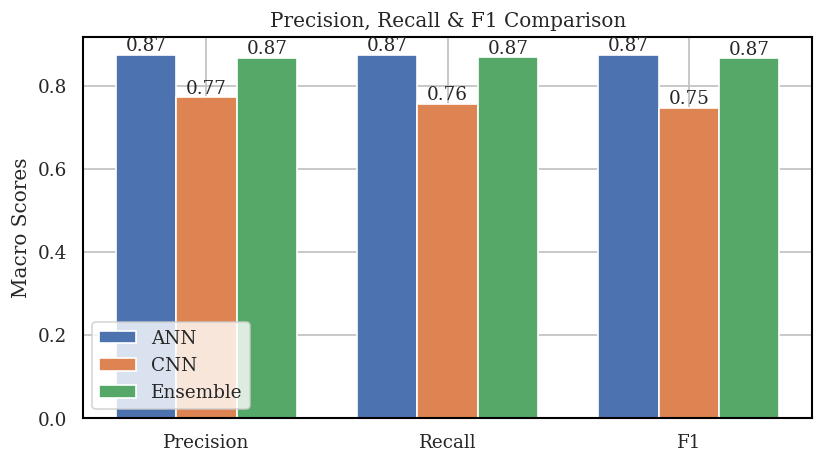

In [ ]:
metrics = ["Precision", "Recall", "F1"]
ann_metrics = [ann_precision, ann_recall, ann_f1]
cnn_metrics = [cnn_precision, cnn_recall, cnn_f1]
ens_metrics = [ens_precision, ens_recall, ens_f1]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(7,4))
plt.bar(x - width, ann_metrics, width, label='ANN')
plt.bar(x, cnn_metrics, width, label='CNN')
plt.bar(x + width, ens_metrics, width, label='Ensemble')

plt.xticks(x, metrics)
plt.ylabel("Macro Scores")
plt.title("Precision, Recall & F1 Comparison")
plt.legend()

for i, v in enumerate(ann_metrics):
    plt.text(i - width, v + 0.01, f"{v:.2f}", ha='center')
for i, v in enumerate(cnn_metrics):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
for i, v in enumerate(ens_metrics):
    plt.text(i + width, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig(f"{base_dir}/metrics_comparison/PRF_comparison.png")
plt.show()

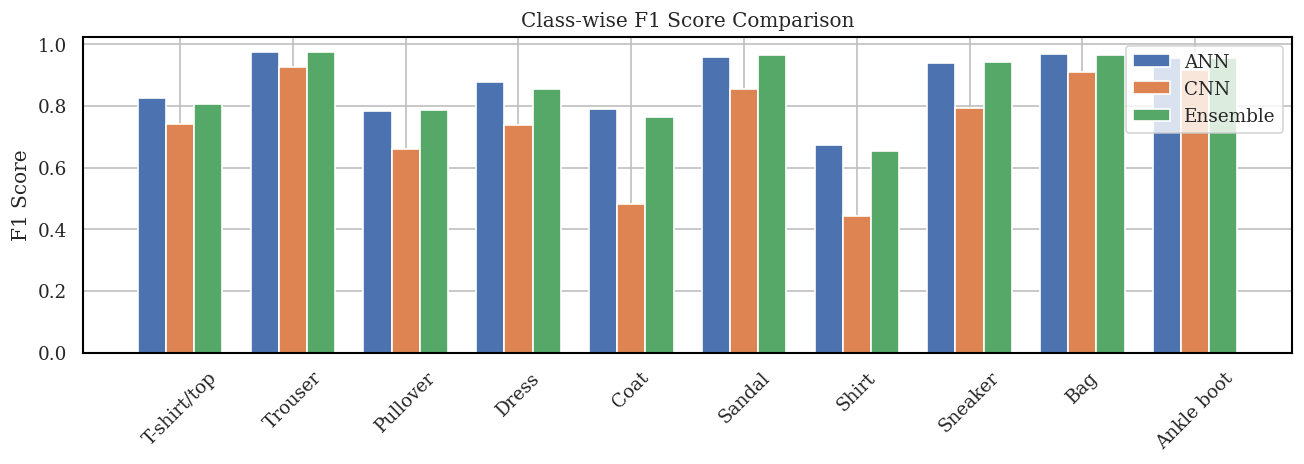

In [ ]:
ann_f1_class = f1_score(test_labels, ann_pred_labels, average=None)
cnn_f1_class = f1_score(test_labels, cnn_pred_labels, average=None)
ens_f1_class = f1_score(test_labels, ensemble_labels, average=None)

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(11,4))
plt.bar(x - width, ann_f1_class, width, label='ANN')
plt.bar(x, cnn_f1_class, width, label='CNN')
plt.bar(x + width, ens_f1_class, width, label='Ensemble')

plt.xticks(x, class_names, rotation=45)
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_dir}/metrics_comparison/classwise_f1.png")
plt.show()

## 1️⃣8️⃣ Grad-CAM on 3 Samples

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_49']]
Received: inputs=Tensor(shape=(1, 28, 28, 1))
  warnings.warn(msg)


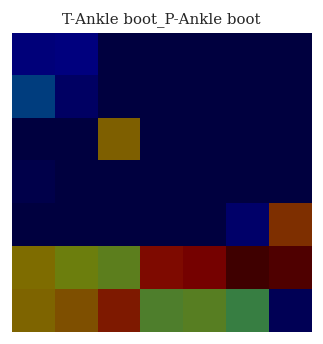

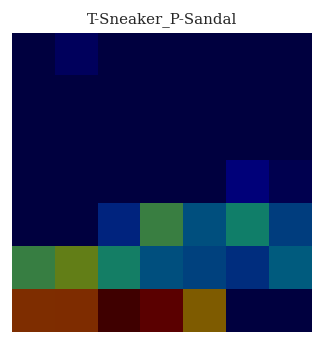

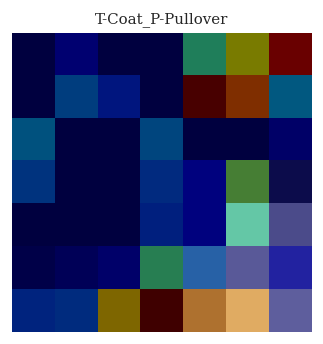


📊 Part 3 Completed: Metrics, Graphs & Grad-CAM Saved Successfully!
📍 New outputs saved to: results/metrics_comparison/ and results/gradcam_3/


In [ ]:
def grad_cam(model, img, true_label, pred_label, title, idx=0):
    conv_layers = [l.name for l in model.layers if isinstance(l, (layers.Conv2D, layers.DepthwiseConv2D))]
    last_conv = conv_layers[-1]

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(np.array([img]))
        loss = preds[:, true_label]

    grads = tape.gradient(loss, conv_out)[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = np.maximum(np.sum(weights * conv_out[0], axis=-1), 0)
    cam /= np.max(cam)

    plt.figure(figsize=(3,3))
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(title, fontsize=9)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{base_dir}/gradcam_3/gradcam_{idx+1}_{title.replace(' ','_')}.png")
    plt.show()

correct_idx = np.where(ensemble_labels == test_labels)[0][:1]
wrong_idx = np.where(ensemble_labels != test_labels)[0][:2]
selected_idx = list(correct_idx) + list(wrong_idx)

for i, idx in enumerate(selected_idx):
    t = test_labels[idx]
    p = ensemble_labels[idx]
    title = f"T-{class_names[t]}_P-{class_names[p]}"
    grad_cam(cnn_model, test_images_cnn[idx], t, p, title, idx=i)

print("\n📊 Part 3 Completed: Metrics, Graphs & Grad-CAM Saved Successfully!")
print("📍 New outputs saved to: results/metrics_comparison/ and results/gradcam_3/")